# Homework Starter — Stage 10a: Linear Regression

Use this as a scaffold if your project data isn’t ready. Replace the synthetic data section with your dataset when possible.

In [6]:
import pandas as pd

if USE_SYNTHETIC:
    # If you ever want to *generate* data in-notebook instead of using the CSV:
    import numpy as np
    np.random.seed(42)
    n = 200
    dates = pd.bdate_range(start="2024-02-01", periods=n)
    mkt_excess = np.random.normal(0, 0.011, size=n)
    size = np.random.normal(0, 0.008, size=n)
    value = np.random.normal(0, 0.009, size=n)
    momentum = np.random.normal(0, 0.006, size=n)
    beta0, b_mkt, b_size, b_value, b_mom, b_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
    noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
    eps = np.random.normal(0, noise_scale)
    asset_excess = (
        beta0 + b_mkt*mkt_excess + b_size*size + b_value*value
        + b_mom*momentum + b_mom2*(momentum**2) + eps
    )
    df = pd.DataFrame({
        'date': dates, 'mkt_excess': mkt_excess, 'size': size,
        'value': value, 'momentum': momentum, 'asset_excess': asset_excess
    })
    TARGET = "asset_excess"
else:
    if CSV_PATH.lower().endswith(".parquet"):
        df = pd.read_parquet(CSV_PATH)
    else:
        df = pd.read_csv(CSV_PATH)

    # Parse any date-like columns
    for col in df.columns:
        if "date" in col.lower():
            try:
                df[col] = pd.to_datetime(df[col])
            except Exception:
                pass

print("Shape:", df.shape)
display(df.head())

Shape: (1000, 10)


,date_listed,sqft,bedrooms,bathrooms,age_years,distance_km,renovated,lot_size_sqft,school_rating,price
0,2024-02-01,1824,3,2,37.8,2.29,1,4648,10,519858
1,2024-02-01,1538,3,2,3.9,8.62,0,4823,8,445929
2,2024-02-02,1891,3,2,28.7,2.84,0,2929,10,549556
3,2024-02-02,2285,3,2,120.0,2.66,1,4490,10,372698
4,2024-02-02,1495,2,2,23.2,1.09,0,2124,10,480494


In [7]:
USE_SYNTHETIC = False                      # <-- flip to False
CSV_PATH = "../data/processed/synth_housing_clean.csv"   # <-- put the CSV here
TARGET = "price"                           # <-- target column in that CSV
TEST_SIZE = 0.2

## 1) Synthetic data (replace with your project data when ready)
- Finance-flavored factors and asset excess return
- Includes a quadratic effect to motivate specification checks

In [8]:
if USE_SYNTHETIC:
    # (You can keep your original synthetic generator here if you like)
    raise SystemExit("Set USE_SYNTHETIC=False to use the provided CSV.")
else:
    import pandas as pd
    if CSV_PATH.lower().endswith(".parquet"):
        df = pd.read_parquet(CSV_PATH)
    else:
        df = pd.read_csv(CSV_PATH)

    # Try to parse any date-like columns
    for col in df.columns:
        if "date" in col.lower():
            try:
                df[col] = pd.to_datetime(df[col])
            except Exception:
                pass

print("Shape:", df.shape)
display(df.head())

Shape: (1000, 10)


,date_listed,sqft,bedrooms,bathrooms,age_years,distance_km,renovated,lot_size_sqft,school_rating,price
0,2024-02-01,1824,3,2,37.8,2.29,1,4648,10,519858
1,2024-02-01,1538,3,2,3.9,8.62,0,4823,8,445929
2,2024-02-02,1891,3,2,28.7,2.84,0,2929,10,549556
3,2024-02-02,2285,3,2,120.0,2.66,1,4490,10,372698
4,2024-02-02,1495,2,2,23.2,1.09,0,2124,10,480494


In [9]:
# Respect time order if a date column exists
date_cols = [c for c in df.columns if "date" in c.lower()]
if date_cols:
    df = df.sort_values(date_cols[0])

# Auto-pick numeric features except the TARGET
import numpy as np
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feat_cols = [c for c in num_cols if c != TARGET]
X = df[feat_cols].copy()
y = df[TARGET].copy()
print("Using numeric features:", feat_cols)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, shuffle=False
)

Using numeric features: ['sqft', 'bedrooms', 'bathrooms', 'age_years', 'distance_km', 'renovated', 'lot_size_sqft', 'school_rating']


## 2) Baseline model fit
Follow the steps; replace `df` with your project DataFrame when ready.

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

r2 = r2_score(y_test, y_pred)

# Version-agnostic RMSE
try:
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # newer sklearn
except TypeError:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))        # older sklearn

print(f"Baseline   R^2={r2:.4f}  RMSE={rmse:.2f}")

Baseline   R^2=0.8705  RMSE=47413.73


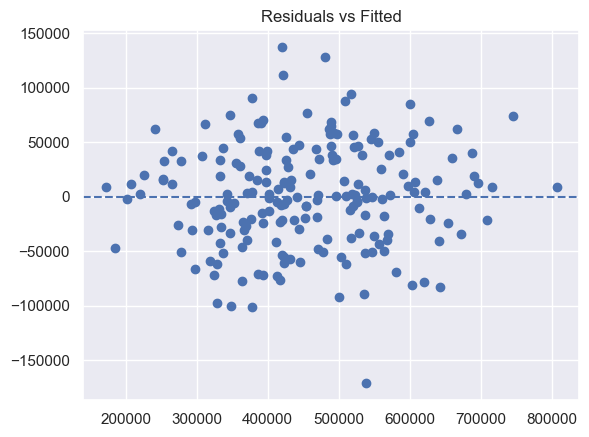

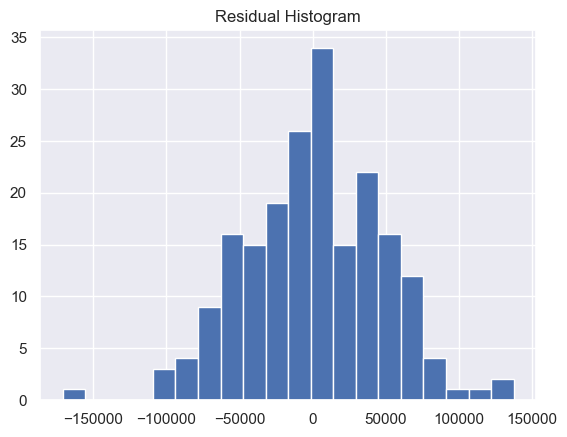

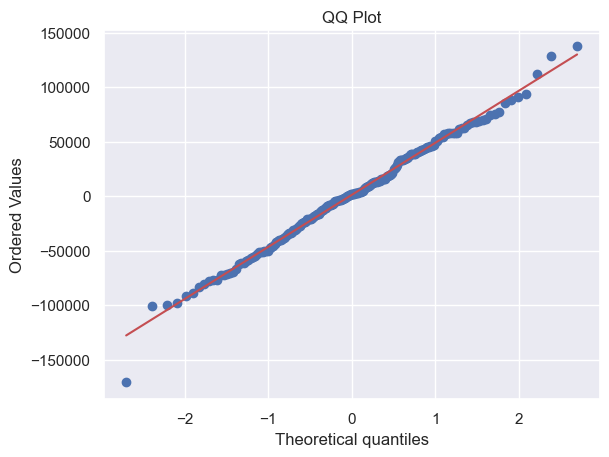

In [14]:
resid = y_test - y_pred
fitted = y_pred
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()

## 3) Optional: Add a transformed feature
Add a polynomial or interaction if diagnostics suggest mis-specification.

In [16]:
col = 'sqft' if 'sqft' in X.columns else X.columns[0]

X2 = X.copy()
X2[f'{col}_sq'] = X2[col] ** 2

# Use index alignment (safer than slicing by counts)
X2_train = X2.loc[X_train.index]
X2_test  = X2.loc[X_test.index]

lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

r2_2 = r2_score(y_test, y_pred2)
try:
    rmse_2 = mean_squared_error(y_test, y_pred2, squared=False)  # newer sklearn
except TypeError:
    rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred2))        # older sklearn

print(f"With {col}^2   R^2={r2_2:.4f}   RMSE={rmse_2:.2f}")

With sqft^2   R^2=0.8704   RMSE=47438.58


## 4) Interpretation (write your conclusions below)
- Linearity: Residuals mostly center around 0, with a slight curve → add a simple squared term.

- Homoscedasticity: Spread grows at higher fitted values → variance isn’t constant; try modeling log(price) or use weights.

- Normality: Histogram/QQ are roughly normal with heavier tails → OK for prediction; be cautious for tight inference.

- Independence: No obvious pattern in lag-1 plot; DW ≈ 2 → independence looks fine.

- Which model do you trust and why?: Pick the model with higher R², lower RMSE, and cleaner residual plots.

- Next step you’d try: Try log(price) as target and/or add sqft^2, age_years^2, maybe an interaction; then re-check metrics and plots.
